In [1]:
import tensorflow as tf
tf.__version__

'2.1.0'

In [2]:
from __future__ import print_function, division

#Se importan las bibliotecas. En caso de querer hacer este proceso directamente
#en un ordenador se deben instalar las bilbiotecas que se indican a continuacion:

import numpy as np
import cv2
import matplotlib.pyplot as plt
import pickle
import h5py
import sklearn
import glob
import keras
import time
import imp
import os
import tensorflow as tf 
import pandas as pd
import sys

#Estas bibliotecas no son necesarias en su totalidad, solo se requieren ciertas
#funciones
from random import shuffle
from skimage import io
from collections import Counter
from PIL import Image, ImageFont, ImageDraw, ImageEnhance


from keras.datasets import mnist

#Importe de funciones especificas de bibliotecas ya importadas
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler, ModelCheckpoint
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout, Activation, Flatten, Reshape
from keras.layers import BatchNormalization, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.convolutional import UpSampling2D
from keras.optimizers import SGD, Adam

#lineas requeridas solo en jupyter notbook
%matplotlib inline
#%tensorflow_version 2.x

Using TensorFlow backend.
UsageError: Line magic function `%tensorflow_version` not found.


In [3]:
#Se inicia definiendo el diccionario map_characters, este posee originalmente 18
#personajes, si se agrega otro más se debe agregar al diccionario y colocarsele 
#el número consecutivo que corresponda
map_characters = {0: '0', 
                  1: '1', 
                  2: '2',
                  3: '3', 
                  4: '4', 
                  5: '5', 
                  6: '6', 
                  7: '7', 
                  8: '8', 
                  9: '9'}
                  
#Se define el numero de clases con la extensión del diccionario
num_classes = len(map_characters)

#Número máximo de imagenes que se usaran por personaje para entrenar
pictures_per_class = 1000

def load_pictures(test_size, pic_size,BGR):
    """
    Load pictures from folders for characters from the map_characters dict and create a numpy dataset and 
    a numpy labels set. Pictures are re-sized into picture_size square.
    :param BGR: boolean to use true color for the picture (RGB instead of BGR for plt)
    :return: dataset, labels set
    """
    pics = []    #Se crea la lista de imagenes de salida
    labels = []  #Se crea la lista de etiquetas de salida

    #k es el numero de la variable en el diccionario
    #char es el nombre de la variable en el diccionario
    # El if lo que hace es que recorra cada una de las variables del diccionario
    for k, char in map_characters.items(): 

        #Esta linea deivuelve la lista de rutas de las imagenes de cada personaje del diccionario
        # Ej: para char = 'abraham_grampa_simpson' regresa todas las rutas de imagen de la carpeta
        # abraham_grampa_simpson que a su vez esta en la carpeta characters.
        #Es solo una forma elegante y rapida de optener todas las rutas
        pictures = [k for k in glob.glob('../source/trainingSet/trainingSet//%s/*' % char)]

        #Se establece la cantidad de imagenes que se van a usar en cada clase
        #Como maximo se usan 1176 imagenes, estas son tanto para train como para test
        #Si el personaje en particular tiene menos de 1176 imagenes se usara la extension del personaje en cuestion
        nb_pic = round(pictures_per_class/(1-test_size)) if round(pictures_per_class/(1-test_size))<len(pictures) else len(pictures)

        #Se usa la funcion random para ordenar de manera aleatoria las imagenes de cada personaje
        #Cabe detacar que pic es una ruta de acceso aleatoria de la lista de rutas de acceso en pictures
        for pic in np.random.choice(pictures, nb_pic):

            #Se lee la imagen de la ruta "pic"
            a = cv2.imread(pic)
            # a = cv2.imread(pic, cv2.IMREAD_GRAYSCALE)

            #Si se desea se usa RGB se hace la transformacion de BGR, que es la lectura original
            #Por defecto este cambio no se hace a menos que se especifique
            if BGR:
                a = cv2.cvtColor(a, cv2.COLOR_BGR2GRAY)
            
            #Se hace un resize de las imagenes a pic_size x pic_size. Por defecoto
            #este es 64x64. Esto concuerda con los pixeles de entrada de la red neuronal
            a = cv2.resize(a, (pic_size,pic_size))

            #Se agrega la imagen leida, convertida y escalada a la lista pics
            pics.append(a)
            #Se agrega la etiqueta numérica de la lista de etiquetas, esta etiqueta numerica 
            #concuerda con el número en el diccionario map_characters
            labels.append(k)

    #Se devuelve las listas pero antes se transforman a un formato de array con numpy
    return np.array(pics), np.array(labels) 

def get_dataset(save=False, load=False, BGR=False, test_size=0.1, pic_size=64):
    #Primero se llama a la funcion load_pictures, por defecto se deja estas en 
    #blanco y negro
    #En esta funcion tambien se extraen los labels del archivo txt anotations
    X, y = load_pictures(test_size, pic_size, BGR)

    #Luego se pasa los labels a un formato numerico y en listas separadas,
    #por ejemplo si el label es 2 to_categorical lo pasa a una lista [0 0 1 ... 0]
    #El tamaño de la lista depende de cuantas clases se tenga, en este ejemplo son 18
    y = keras.utils.to_categorical(y, num_classes)

    #Se normaliza las imagenes para que los valores de cada banda esten en punto flotante
    #y además se encuentren entre 0 y 1. Esto ayuda a la velocidad de entrenamiento           
    X = X.astype('float32') / 255.
    
    #Se imprime las formas de cada tensor. Si se mantienen todas las variables 
    #por defecto estas deben ser (x,64,64,3) y (x,w), donde x es el numero de imagenes
    #y w es la cantidad de clases en el diccionario
    print("Train", X.shape, y.shape)

    return X, y

#Uso de funciones de lectura para dividir el set de imagnes en test y train
X, y = get_dataset(save=True)

Train (11110, 64, 64, 3) (11110, 10)


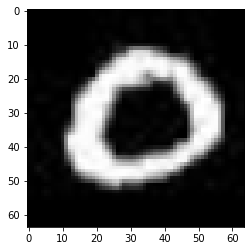

In [4]:
fig, axs = plt.subplots(1, 1)

axs.imshow(X[0])
plt.show()
axs.axis('off')
fig.savefig("images2.png")
plt.close()

In [5]:
img_rows = 64
img_cols = 64
channels = 3
latent_dim = 100
img_shape = (img_rows, img_cols, channels)
img_shape

(64, 64, 3)

In [6]:
def build_generator():

    model = Sequential()

    model.add(Dense(256 * 16 * 16, input_dim=100))
    model.add(Reshape((16, 16, 256)))
    
    model.add(UpSampling2D())
    model.add(Conv2D(128, kernel_size=3, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))
    
    model.add(UpSampling2D())
    model.add(Conv2D(64, kernel_size=3, padding="same"))
    model.add(BatchNormalization(momentum=0.9))
    model.add(Activation("relu"))
    
    model.add(Conv2D(channels, kernel_size=3, padding="same"))
    model.add(Activation("sigmoid"))

    model.summary()

    noise = Input(shape=(latent_dim,))
    img = model(noise)

    return Model(noise, img)

In [7]:
def build_discriminator():

    
    #Se crea primeramente un modelo "Sequential", este es el tipo de red neuronal
    #existen otros tipos como las recursivas y las recurrentes.
    
    model = Sequential()
    
    #Se usa mucho las capas Conv2D, por lo que se explicara solo una vez. Estas 
    #tienen el formato por defecto:
    
    #tf.keras.layers.Conv2D(
    #    filters, kernel_size, strides=(1, 1), padding='valid', data_format=None,
    #    dilation_rate=(1, 1), activation=None, use_bias=True,
    #    kernel_initializer='glorot_uniform', bias_initializer='zeros',
    #    kernel_regularizer=None, bias_regularizer=None, activity_regularizer=None,
    #    kernel_constraint=None, bias_constraint=None, **kwargs)
    #
    #Donde:
    #"filters" se refiere a la cantidad de filtros que se tienen en esa capa, 
    #por ejemplo en la primera capa se tiene 32 filtros.
    #Los filtros son los que cambuan durante el entrenamiento.
    
    #"strides" es siempre una tupla. Se refiere a las dimenciones dadas para 
    #cada filtro, por defecto esta variable tiene como valor la tupla (1,1). 
    #Por ejemplo, en la primera capa se usa una dimensión para los filtros (3,3)
    
    #"padding" es una bandera que puede ser "valid" (opcion por defecto) 
    #o "same" (case-insensitive). La opción valid tiene la posibilidad de perder
    #informacion de entrada en especial de las esquinas. Por otra parte same
    #aplica rellenos en las esquinas de modo que se usen todos los pixeles de entrada

    #"input_shape" se usa solo en la capa (layer) de entrada

    #¿Que recibe de entrada y que obtiene de salida estas capas?
    #La entrada debe ser un tensor de 4D con el formato:
    #   (batch_size, rows, cols, channels), si data_format='channels_last' esta 
    #     es la opcion por defecto de "data_format"
    #
    #   (batch_size, channels, rows, cols), si data_format='channels_first'
    #
    #La salida es otro tensor de 4D con el formato:
    #   (batch_size, new_rows, new_cols, filters), si data_format='channels_last' 
    #     esta es la opcion por defecto de "data_format"
    #
    #   (batch_size, filters, new_rows, new_cols), si data_format='channels_first' 
    #
    #rows and cols pueden variar dependiendo de la bandera "padding", con "same"
    #se tendrían la misma candtidad de rows y cols de salida que de entrada.

    #Primera capa convolucional
    model.add(Conv2D(32, kernel_size=3, strides=2, padding='same', input_shape=img_shape))

    #Se agrega una funcion de activación, se puede agregar directamente en la capa
    #convolucional pero esto haría que se pusiera la activación en la entrada, 
    #se decide poner la activación en la salida.
    #La función de activación que se usa es la "relu" pero existen otras funciones
    #de activación, estas se pueden encontrar aqui:
    #https://www.tensorflow.org/api_docs/python/tf/keras/activations 
    #Relu hace que los valores con un valor menor a 1 se vuelvan 0
    model.add(Activation('relu'))

    #Como resultado de la primera capa convolucional se tiene 32 capas de profundidad
    #y cada una de estas capas poseen las mismas dimensiones que la imagen de entrada
    #en caso de mantener la configuracion por defecto se tiene 64x64x32, se puede 
    #ver como un cubo con tres dimensiones: largo, ancho y profundidad 

    #Segunda capa convolucional, con 32 filtros
    #Esta segunda capa sigue siendo convolucional pero notese que no posee el 
    #padding, como resultado se pierde las últimas filas y columnas (los bordes)
    #por lo que para este caso el cubo seria de dimenciones 62x62x32, ya que 
    #aún se tienen los 32 filtros. La función de activación sigue siendo "relu".
    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    
    #Una capa Maxpolling2D reduce la cantidad de col y rows, en este caso
    #se reduce de una matriz 2x2 a un único escalar, como consecuencia se tiene
    #como resultado un cubo 31x31x32.
    #Los layers de pool lo que hacen es reducir la cantidad de filas y columnas
    #de entrada, esto puede hacerse por promedio, minimo, maximo o una función
    #en este caso MaxPooling lo que hace es usar el valor máximo de la matriz que
    #está viendo. (de la matriz 2x2 agarra el valor máximo y ese es el resultado)
    model.add(MaxPooling2D(pool_size=(2, 2)))

    #Las capas dropout se usa para evitar el overfiting, estas solo se activan
    #durante el entrenamiento, y su función es hacer cero entradas de manera aleatoria
    #con un taza de ocurrencia seleccionada por el usuario (en este caso es de 25%)
    #las que no son colocadas en 0 se multiplican por 1/(1-rate)
    model.add(Dropout(0.25))

    #Tercera capa convolucional, con 64 filtros
    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(Activation('relu'))
    
    #Cuarta capa convolucional, con 64 filtros
    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))

    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    #La capa "flatten" lo que hace es pasar de las capas convolucionales y 3D a 
    #capas en una dimensión. Un único vector horizontal.
    model.add(Flatten())
    
    #Se reduce la cantidad de neuronas, en este casi particular se pasa de la cantidad
    #dada por Flatten y se pasa a 512 nueronas, se recomienda siempre usar 2^n valores
    #Esta capa se le conoce como fully connected layer
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    
    #Finalmente se reduce a la cantidad de neuronas equivalentes a la cantidad de clases
    #que se desean, en nuestro caso, la cantidad de personajes que estamos clasificando
    model.add(Dense(1, activation='sigmoid'))

    model.summary()

    img = Input(shape=img_shape)
    validity = model(img)

    return Model(img, validity)


In [8]:
optimizer = Adam(0.0002, 0.5)

# Build and compile the discriminator
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Build the generator
generator = build_generator()

# The generator takes noise as input and generates imgs
z = Input(shape=(latent_dim,))
img = generator(z)

# For the combined model we will only train the generator
discriminator.trainable = False

# The discriminator takes generated images as input and determines validity
valid = discriminator(img)

# The combined model  (stacked generator and discriminator)
# Trains the generator to fool the discriminator
combined = Model(z, valid)
combined.compile(loss='binary_crossentropy', optimizer=optimizer)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 64)       

In [9]:
def save_imgs(epoch):
    r, c = 5, 5
    noise = np.random.normal(0, 1, (r * c, latent_dim))
    gen_imgs = generator.predict(noise)

    # Rescale images 0 - 1
    gen_imgs = abs(gen_imgs)

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow((gen_imgs[cnt] * 255).astype(int))
            axs[i,j].axis('off')
            cnt += 1
    fig.savefig("Resultados/mnist2_%d.png" % epoch)
    plt.close()

In [10]:
def train(epochs, batch_size=128, save_interval=50):

    # Load the dataset
    X_train, y = get_dataset(save=True)
    
    #X_train = np.expand_dims(X_train, axis=3)

    # Adversarial ground truths
    valid = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    for epoch in range(epochs):

        # Se seleccionan imagenes aleatorias para hacer la epoca
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs = X_train[idx]

        # El generador da un numero de imagenes sinteticas para la epoca
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        gen_imgs = generator.predict(noise)

        # ---------------------
        #  Train Discriminator
        # ---------------------
        
        #Se entrena con las imagenes reales
        d_loss_real = discriminator.train_on_batch(imgs, valid)
        
        #Se entrena con las imagenes creadas como falsas
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # ---------------------
        #  Train Generator
        # ---------------------

        # Se ingresa el ruido al sistema combinado, la idea es que
        # el generador engañe al discriminador para que piense que es
        # una imagen real
        g_loss = combined.train_on_batch(noise, valid)

        # Se imprime el progreso
        # If at save interval => save generated image samples
        if epoch % save_interval == 0:
            print ("%d Discriminator_loss: %f acc.: %.2f%% Generator_loss: %f" % (epoch, d_loss[0], 100*d_loss[1], g_loss))
            save_imgs(epoch)

In [ ]:
!mkdir images2

In [ ]:
train(epochs=80000, batch_size=16, save_interval=500)

Train (11110, 64, 64, 3) (11110, 10)


C:\Users\santi\anaconda3\envs\gpu2\lib\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
C:\Users\santi\anaconda3\envs\gpu2\lib\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 Discriminator_loss: 0.780383 acc.: 34.38% Generator_loss: 0.594571


C:\Users\santi\anaconda3\envs\gpu2\lib\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


500 Discriminator_loss: 0.533541 acc.: 65.62% Generator_loss: 1.007223
1000 Discriminator_loss: 0.601329 acc.: 59.38% Generator_loss: 0.722053


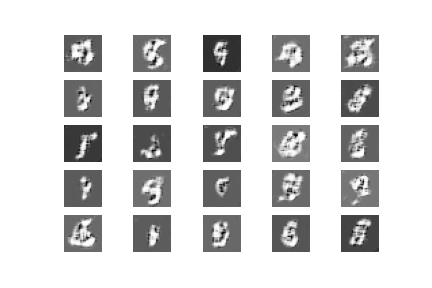

In [31]:
from IPython.display import display
from PIL import Image

path="images/mnist_0.png"
display(Image.open(path))

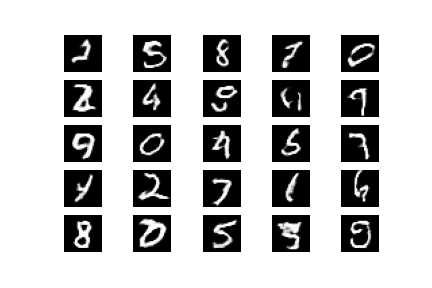

In [30]:
from IPython.display import display
from PIL import Image

path="images/mnist_80000.png"
display(Image.open(path))